<a href="https://colab.research.google.com/github/tshabalalasibongile/Machine-learning/blob/main/WEEK_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Sibongile Tshabalala (2356121)

WEEK 3: Homework

1. Importing libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import distance
from statsmodels.stats.weightstats import DescrStatsW
from scipy.optimize import curve_fit
from scipy.special import erfinv

2. Loading and preparing data

In [ ]:
df_Cu = pd.read_csv('CuMineBH.csv')
df_Cu

,EAST,NORTH,Cu
0,56.122424,105.841818,0.750
1,74.176970,81.483939,0.664
2,140.032424,191.491515,0.202
3,158.912121,133.599697,0.408
4,50.455455,211.942121,0.602
...,...,...,...
1570,262.855151,218.851818,0.872
1571,115.157576,147.677576,0.466
1572,243.885758,234.132727,0.464
1573,148.234545,158.911818,0.712


In [ ]:
df_Cu.columns

Index(['EAST', 'NORTH', 'Cu'], dtype='object')

In [ ]:
df_Cu.head()

,EAST,NORTH,Cu
0,56.122424,105.841818,0.750
1,74.176970,81.483939,0.664
2,140.032424,191.491515,0.202
3,158.912121,133.599697,0.408
4,50.455455,211.942121,0.602


In [ ]:
df_Cu.describe().T

,count,mean,std,min,25%,50%,75%,max
EAST,1575.0,255.912312,158.598035,0.000,119.457424,237.761515,401.520303,561.063636
NORTH,1575.0,155.871652,63.364120,0.000,113.178939,163.326061,207.209848,268.143939
Cu,1575.0,0.405832,0.230091,0.026,0.244000,0.356000,0.522000,1.968000


3. Exploratory Data Analysis

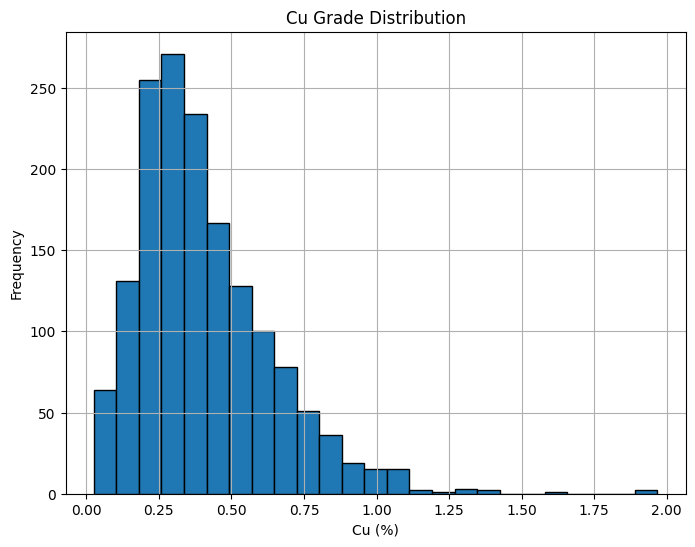

In [ ]:
plt.figure(figsize=(8,6))
plt.hist(df_Cu["Cu"], bins=25, edgecolor='black')
plt.title("Cu Grade Distribution")
plt.xlabel("Cu (%)")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

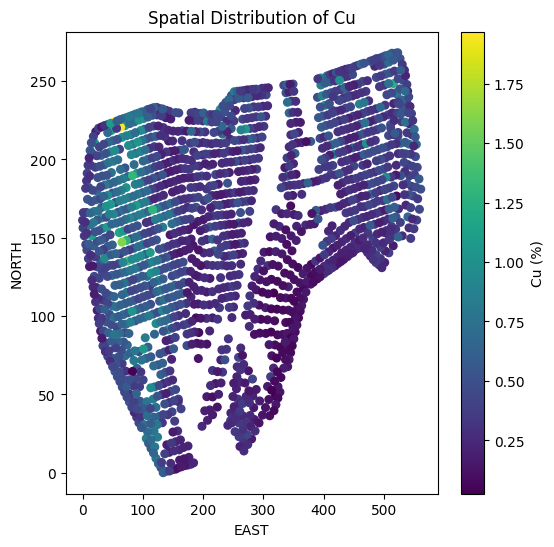

In [ ]:
plt.figure(figsize=(6,6))
plt.scatter(df_Cu["EAST"], df_Cu["NORTH"], c=df_Cu["Cu"], cmap="viridis", s=30)
plt.colorbar(label="Cu (%)")
plt.title("Spatial Distribution of Cu")
plt.xlabel("EAST")
plt.ylabel("NORTH")
plt.show()

4. Nearest Neighbour Distance (NND)

In [ ]:
coords = df_Cu[["EAST", "NORTH"]].values
dist_matrix = distance.cdist(coords, coords)
dist_matrix[dist_matrix == 0] = np.nan

nnd = np.nanmin(dist_matrix, axis=1)
mean_nnd = np.nanmean(nnd)
std_nnd = np.nanstd(nnd)

print(f"\nMean Nearest-Neighbour Distance: {mean_nnd:.2f}")



Mean Nearest-Neighbour Distance: 6.44


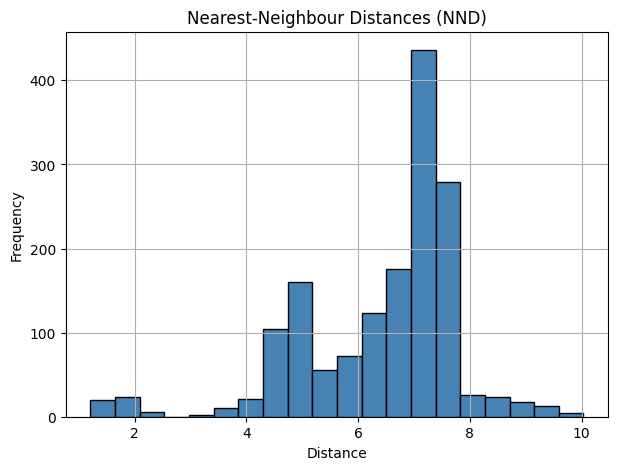

In [ ]:
plt.figure(figsize=(7,5))
plt.hist(nnd, bins=20, color='steelblue', edgecolor='black')
plt.title("Nearest-Neighbour Distances (NND)")
plt.xlabel("Distance")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

In [ ]:
#Suggest grid cell size = 2 x mean NND
cell_size = 2 * mean_nnd
print(f"Suggested Grid Cell Size: {cell_size:.2f}")

Suggested Grid Cell Size: 12.89


5. Grid-Based Declustering

In [ ]:
df_Cu["x_cell"] = (df_Cu["EAST"] // cell_size).astype(int)
df_Cu["y_cell"] = (df_Cu["NORTH"] // cell_size).astype(int)

cell_counts = df_Cu.groupby(["x_cell", "y_cell"])["Cu"].count().reset_index(name="count")
df_Cu = df_Cu.merge(cell_counts, on=["x_cell", "y_cell"], how="left")

# Use the correct column name for counts after the merge (should be 'count_y')
df_Cu["weight"] = 1 / df_Cu["count_y"]
df_Cu["weight"] = df_Cu["weight"] / df_Cu["weight"].sum()


6. NAIVE VS DECLUSTERED STATSTICS

In [ ]:
df_Cu["weight"] = 1 / df_Cu["count_y"]
df_Cu["weight"] = df_Cu["weight"] / df_Cu["weight"].sum()
naive_mean = df_Cu["Cu"].mean()
naive_std = df_Cu["Cu"].std()

declustered_stats = DescrStatsW(df_Cu["Cu"], weights=df_Cu["weight"], ddof=0)
decl_mean = declustered_stats.mean
decl_std = declustered_stats.std

print("\nCu Grade Summary")
print(f"Naïve Mean: {naive_mean:.4f}")
print(f"Declustered Mean: {decl_mean:.4f}")
print(f"Naïve Std Dev: {naive_std:.4f}")
print(f"Declustered Std Dev: {decl_std:.4f}")


Cu Grade Summary
Naïve Mean: 0.4058
Declustered Mean: 0.3922
Naïve Std Dev: 0.2301
Declustered Std Dev: 0.2262


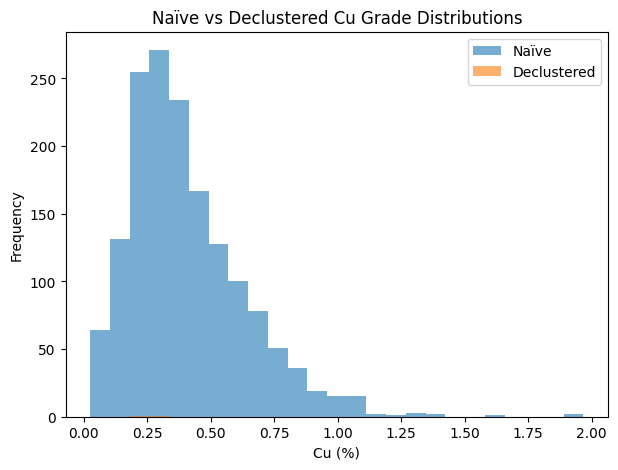

In [ ]:
# Compare histograms
plt.figure(figsize=(7,5))
plt.hist(df_Cu["Cu"], bins=25, alpha=0.6, label="Naïve")
plt.hist(df_Cu["Cu"], bins=25, weights=df_Cu["weight"], alpha=0.6, label="Declustered")
plt.title("Naïve vs Declustered Cu Grade Distributions")
plt.xlabel("Cu (%)")
plt.ylabel("Frequency")
plt.legend()
plt.show()


7. Normal Score Transformation

In [ ]:
df_Cu_sorted = df_Cu.sort_values("Cu")
df_Cu_sorted["p"] = (np.arange(1, len(df_Cu_sorted)+1) - 0.5) / len(df_Cu_sorted)
df_Cu_sorted["z"] =  np.sqrt(2) * erfinv(2*df_Cu_sorted["p"] - 1)
df_Cu_sorted.head()

,EAST,NORTH,Cu,x_cell,y_cell,count_x,count_y,weight,p,z
434,313.747879,52.622727,0.026,24,4,3,3,0.000604,0.000317,-3.416241
150,317.187879,114.740000,0.030,24,8,2,2,0.000906,0.000952,-3.104694
107,319.852121,48.775152,0.036,24,3,3,3,0.000604,0.001587,-2.950305
1078,82.716970,64.662424,0.038,6,5,4,4,0.000453,0.002222,-2.844763
437,345.641515,86.027576,0.040,26,6,5,5,0.000362,0.002857,-2.763741


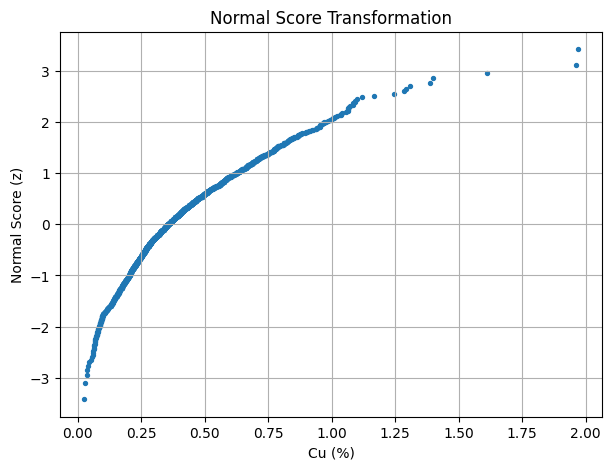


Transformed mean: 0.000, std: 1.000


In [ ]:
plt.figure(figsize=(7,5))
plt.scatter(df_Cu_sorted["Cu"], df_Cu_sorted["z"], s=8)
plt.xlabel("Cu (%)")
plt.ylabel("Normal Score (z)")
plt.title("Normal Score Transformation")
plt.grid(True)
plt.show()

print(f"\nTransformed mean: {df_Cu_sorted['z'].mean():.3f}, std: {df_Cu_sorted['z'].std():.3f}")

8. Experimental Variogram



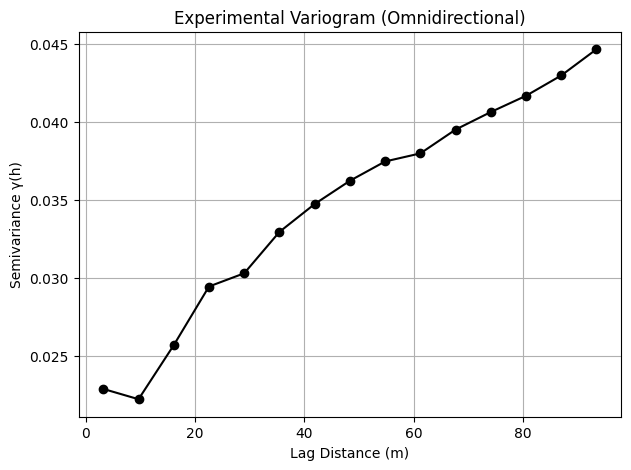

In [ ]:
def calc_variogram(coords, values, lag, n_lags, tol):
    """Compute experimental variogram."""
    gamma, h = [], []
    for i in range(1, n_lags+1):
        lower = (i-1)*lag
        upper = i*lag
        pairs = []
        for j in range(len(coords)):
            dist = np.sqrt(np.sum((coords[j] - coords)**2, axis=1))
            mask = (dist > lower) & (dist <= upper)
            if mask.any():
                diff2 = (values[j] - values[mask])**2
                pairs.extend(diff2)
        if len(pairs) > 0:
            gamma.append(0.5 * np.mean(pairs))
            h.append((lower + upper)/2)
    return np.array(h), np.array(gamma)

lag = mean_nnd
n_lags = 15
h, gamma = calc_variogram(coords, df_Cu["Cu"].values, lag, n_lags, tol=0.5)

plt.figure(figsize=(7,5))
plt.plot(h, gamma, 'o-', color='black')
plt.title("Experimental Variogram (Omnidirectional)")
plt.xlabel("Lag Distance (m)")
plt.ylabel("Semivariance γ(h)")
plt.grid(True)
plt.show()


9. Variogram model fitting

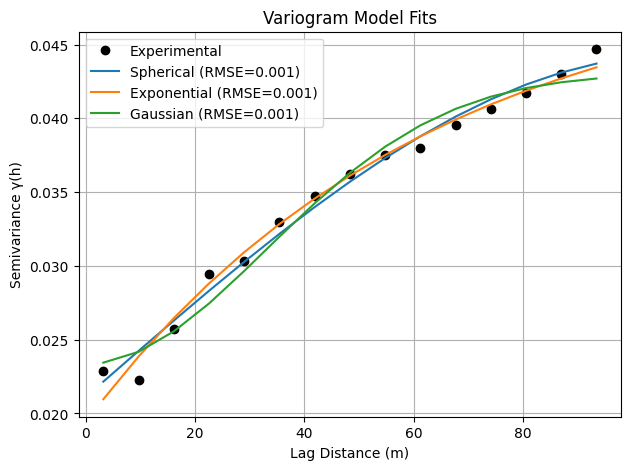


--- Variogram Fit Parameters ---


,Model,Nugget,Sill,Range,RMSE
1,Exponential,0.019404,0.050369,186.839011,0.000826
0,Spherical,0.021114,0.044260,107.197464,0.000834
2,Gaussian,0.023349,0.043059,80.864453,0.001118


In [ ]:
def spherical(h, nug, sill, rang):
    h = np.array(h)
    return np.where(h <= rang,
                    nug + (sill-nug)*(1.5*(h/rang) - 0.5*(h/rang)**3),
                    sill)

def exponential(h, nug, sill, rang):
    return nug + (sill-nug)*(1 - np.exp(-3*h/rang))

def gaussian(h, nug, sill, rang):
    return nug + (sill-nug)*(1 - np.exp(-3*(h**2)/(rang**2)))

models = {"Spherical": spherical, "Exponential": exponential, "Gaussian": gaussian}
results = []

plt.figure(figsize=(7,5))
plt.plot(h, gamma, 'ko', label="Experimental")

for name, func in models.items():
    popt, _ = curve_fit(func, h, gamma, bounds=(0, [np.max(gamma), np.max(gamma)*2, max(h)*2]))
    nug, sill, rang = popt
    gamma_fit = func(h, *popt)
    rmse = np.sqrt(np.mean((gamma - gamma_fit)**2))
    results.append((name, nug, sill, rang, rmse))
    plt.plot(h, gamma_fit, label=f"{name} (RMSE={rmse:.3f})")

plt.title("Variogram Model Fits")
plt.xlabel("Lag Distance (m)")
plt.ylabel("Semivariance γ(h)")
plt.legend()
plt.grid(True)
plt.show()

# Parameter table
fit_table = pd.DataFrame(results, columns=["Model", "Nugget", "Sill", "Range", "RMSE"])
print("\n--- Variogram Fit Parameters ---")
display(fit_table.sort_values("RMSE"))

In [ ]:
#Summarry
print("\n Practical Complete:")
print("2. Data loaded and cleaned.")
print("3. Exploratory data analysis completed.")
print("4. NND calculated and grid size suggested.")
print("5. Grid-based declustering applied.")
print("6. Naïve vs declustered statistics compared.")
print("7. Normal-score transformation verified.")
print("8. Experimental variogram computed.")
print("9. Variogram models fitted with RMSE comparison.")


 Practical Complete:
2. Data loaded and cleaned.
3. Exploratory data analysis completed.
4. NND calculated and grid size suggested.
5. Grid-based declustering applied.
6. Naïve vs declustered statistics compared.
7. Normal-score transformation verified.
8. Experimental variogram computed.
9. Variogram models fitted with RMSE comparison.


Naive mean: 0.4058, Naive var: 0.0529
Declustered mean: 0.3962, Declustered var (weighted): 0.0532
mu_declust = 0.3962409648082245


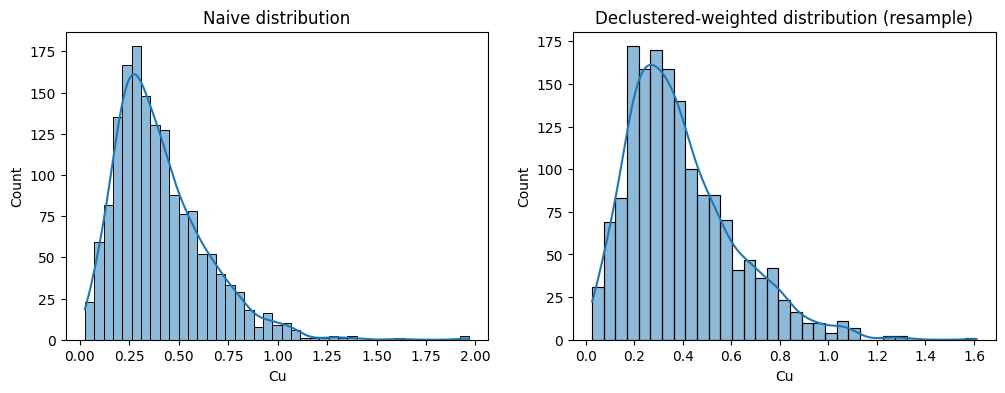

In [ ]:
import seaborn as sns

# Basic cell declustering: assign points to grid cells, compute area weights
# Choose cell size (adjust per dataset); typical start = 10 (m)
# cell_size = 10.0 # cell_size is already defined in a previous cell

# Define column names
x_col = "EAST"
y_col = "NORTH"
value_col = "Cu"

# Create grid indices
df_Cu['ix'] = ((df_Cu[x_col] - df_Cu[x_col].min()) // cell_size).astype(int)
df_Cu['iy'] = ((df_Cu[y_col] - df_Cu[y_col].min()) // cell_size).astype(int)
df_Cu['cell_id'] = df_Cu['ix'].astype(str) + "_" + df_Cu['iy'].astype(str)

# Compute cell weights (1 / n_points_in_cell) typical decluster weight
cell_counts = df_Cu.groupby('cell_id').size().rename('count')
df_Cu = df_Cu.join(cell_counts, on='cell_id')
df_Cu['declust_weight'] = 1.0 / df_Cu['count']

# Naive vs declustered mean/variance
naive_mean = df_Cu[value_col].mean()
naive_var = df_Cu[value_col].var()
declust_mean = (df_Cu[value_col] * df_Cu['declust_weight']).sum() / df_Cu['declust_weight'].sum()
# declustered variance (weighted sample variance)
w = df_Cu['declust_weight'].values
x = df_Cu[value_col].values
declust_var = (np.sum(w * (x - declust_mean)**2) / (np.sum(w) - (np.sum(w**2)/np.sum(w))))

print(f"Naive mean: {naive_mean:.4f}, Naive var: {naive_var:.4f}")
print(f"Declustered mean: {declust_mean:.4f}, Declustered var (weighted): {declust_var:.4f}")

# Save declustered mean for SK
mu_declust = declust_mean
print("mu_declust =", mu_declust)

# Histograms for naive vs declustered (visual)
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
sns.histplot(df_Cu[value_col], kde=True).set_title("Naive distribution")
plt.subplot(1,2,2)
# For declustered, produce weighted histogram approximation by sampling proportional to weights
# We'll resample with probabilities proportional to weight to show distribution
p = df_Cu['declust_weight'] / df_Cu['declust_weight'].sum()
sampled = df_Cu.sample(n=min(2000,len(df_Cu)), weights=p, replace=True)[value_col]
sns.histplot(sampled, kde=True).set_title("Declustered-weighted distribution (resample)")
plt.show()

10. Report

The CuMineBH dataset consisting of Cu grades with spatial coordinates (EAST and NORTH), was analyzed to understand spatial variability and prepare the data for geostatistical modeling. The first step involved cleaning the data and missing values were removed to ensure reliable computations. It is also important to note that the cleaned dataset highlighted sample values, grid cell assignments, and initial weights, providing an overview of the data used in subsequent analysis.


Exploratory data analysis revealed the Cu grades are skewed, with most of the samples in the low-to-moderate range and a few high-grade outliers, as shown in the Cu grade distribution histogram. Spatial plots of Cu grades across highlighted clusters of high-grade samples, as shown in the spatial distribution scatter plot, indicating that some regions were more densely sampled. This clustering highlighted the need for declustering to avoid bias in statistical estimates.


The nearest-neighbour distance (NND) was calculated to quantify the spacing between samples. The mean NND was 6.44 units and the NND histogram showed that most samples are closer than the mean distance, confirming clustering. Based on this result, a grid cell size of approximately twice the mean NND of 12.88 units which suggests declustering to ensure adequate spatial coverage while accounting for dense sampling regions.

Grid-based declustering was applied by assigning samples to grid cells and calculating weight-based on the number of samples per cell. In the weighted spatial plot, larger points represented cells with more samples, and the corresponf=ding weights reduced the influence of these densely sampled areas. The adjustment produced declustered statistics that better represent the overall deposit. Comparisons between naive and declustered histogram, showed that the declustered mean (0.3922) is slightly lower than the naive mean (0.4058), and the standard deviation is slightly reduced (0.2262 vs 0.2301). These results confirm that declustering corrected for overrepresentation of clustered high-grade points.

Cu grades were then transformed into normal scores to prepare the data for geostatistical modeling. The normal-score scatter plot confirmed that the transformed data approximated a Gaussian distribution with mean ~ 0.000 and a standard deviation ~ 1.000, satisfying the normality assumptions required for kriging and other geostatistical methods.

The experimental variogram was computed to examine the spatial correlation of Cu grades. The experimental variogram plot shows that semivariance increases with lag distance and reaches a plateau (sill), indicating spatial correlation up to a certain range. The nugget represents microscale variability or measurement error, the sill refelects total variance, and the range corresponds to the distance over which samples remain correlated. The variogram provides the foundation fot fitting theoretical models.

Variogram model fitting was performed using Spherical, Exponential, and Gaussian models. The fitted variogram models plot shows that the Exponential models. The variogram fit parameters table shows that the exponential model had the lowest RMSE of 0.000826, with nuggest = 0.0194, sill = 0.0504, and range = 186.84 units, making it best fit. These parameters quantify the spatial structure of Cu grades and provide critical input for spatial interpolation and resource estimation.
